In [19]:
#assumes you have cdo loaded when starting jupyter notebook
#The name of the case and where it is located
caseName = 'MAA2.1.3_CAM4_POP2_CLM4_RTMEBM_CICE4_SGLC_T31_g37_1850_aerodep_modscaling_ciso_final'
casePath = '/glade/scratch/jcoupe/archive/MAA2.1.3_CAM4_POP2_CLM4_RTMEBM_CICE4_SGLC_T31_g37_1850_aerodep_modscaling_ciso_final/ocn/hist/'

#The Range of years to analyze
startYear = 30
endYear = 31

#variable to analyze
var = 'IAGE'

#Longitude to analyze transect at the case: 
transectLong = 4
#Saving Option
savePlot = False
saveLocation = '/glade/u/home/vgarza/Scripts/'

#Case to compare to: 
compareName = 'CESM2.1.3_CAM4_POPECO_CLM4_RTM_CICE5_SGLC_T31_g37_ciso_cocco_2000y_CO2_new_dust'
comparePath = '/glade/scratch/crtabor/archive/CESM2.1.3_CAM4_POPECO_CLM4_RTM_CICE5_SGLC_T31_g37_ciso_cocco_2000y_CO2_new_dust/ocn/hist/'

#The Range of years to analyze for compare
startCYear = 170
endCYear = 171

#longitude to analyze transect at compare case:
compareLong = 71

#option to regrid the case: 
regrid = False
#location to send remap (If selected)
remapLocation = '/glade/scratch/vgarza/ScriptTempOutput/' 

In [20]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import cartopy.util as util
import matplotlib as mpl
from glob import glob



mpl.rcParams['figure.figsize'] = [10,4]
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['savefig.dpi'] = 200

mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['lines.linewidth']= 2.0



# function to take global weighted mean, keeping depth information
def global_mean_3D(vara, weights):
   # print(vara)
    # make sure masking is correct, otherwise we get nans
    weights = np.ma.masked_invalid(weights)
    vara = np.ma.masked_invalid(vara)
    
    # resulting variable should have dimensions of depth and time (x)
    ave = np.zeros([vara.shape[0], vara.shape[1]])

    # loop over time
    for t in np.arange(vara.shape[0]):
    # loop over each depth slice
        for d in np.arange(vara.shape[1]):
      #      print(vara)
            ave[t,d] = np.ma.average(vara[t,d,:,:], weights = weights)
    return ave

dates = []
years = []

if regrid == True:
    for year in range (startYear,endYear+1):
        if year % 5 == 0:
            years.append(str(year).zfill(4) + '-'+ str(1).zfill(2))
        for month in range (1,13):

            case = casePath + caseName + '.pop.h.' + str(year).zfill(4) + '-'+ str(month).zfill(2) + '.nc' #sample one 0020-12.nc'  
            newName = caseName + '_' + str(year).zfill(4) + '-'+ str(month).zfill(2) + '.nc'
            !cdo -s remapbil,r100x116 -selname,$var $case /glade/scratch/vgarza/ScriptTempOutput/$newName &>> /glade/scratch/vgarza/ScriptTempOutput/WarningFile.txt
            #print(case)
            
            dates.append(str(year).zfill(4) + '-'+ str(month).zfill(2))
            
    for year in range (startCYear,endCYear+1):
            for month in range (1,13):
                case = comparePath + compareName + '.pop.h.' + str(year).zfill(4) + '-'+ str(month).zfill(2) + '.nc' #sample one 0020-12.nc' 
                newName = compareName + '_' + str(year).zfill(4) + '-'+ str(month).zfill(2) + '.nc'
                !cdo -s remapbil,r100x116 -selname,$var $case $remapLocation$newName &>> /glade/scratch/vgarza/ScriptTempOutput/WarningFile.txt


            
            if year%5 == 0:
                  print(case)

    data =  xr.open_mfdataset(remapLocation+caseName+'*'+'.nc')
    compareData=xr.open_mfdataset(remapLocation+compareName+'*'+'.nc')
else: 
    
    
    dataCase = []
    compareCase = []
    
    
    for year in range (startYear,endYear+1):
        
        if year % 5 == 0:
            years.append(str(year).zfill(4) + '-'+ str(1).zfill(2))
        
        for month in range (1,13):
          
            case = casePath + caseName + '.pop.h.' + str(year).zfill(4) + '-'+ str(month).zfill(2) + '.nc' #sample one 0020-12.nc' 

            newName = caseName + '_' + str(year).zfill(4) + '-'+ str(month).zfill(2) + '.nc'
            dataCase.extend(sorted(glob(case)))
            
            dates.append(str(year).zfill(4) + '-'+ str(month).zfill(2))
            
    for year in range (startCYear,endCYear+1):
            for month in range (1,13):
                compare = comparePath + compareName + '.pop.h.' + str(year).zfill(4) + '-'+ str(month).zfill(2) + '.nc'
                newName = compareName + '_' + str(year).zfill(4) + '-'+ str(month).zfill(2) + '.nc'
                compareCase.extend(sorted(glob(compare)))


            

            
    data =  xr.open_mfdataset(dataCase)
    
    coords = {'x':'TLONG','y':'TLAT'}
    keepthese=['z_t','time','TAREA','lat','lon', 'time', var]
    keep_vars = keepthese +list(coords.values())
    data = data.drop([v for v in data.variables if v not in keep_vars])

    
    
    compareData = xr.open_mfdataset(compareCase)
    coords = {'x':'TLONG','y':'TLAT'}
    keepthese=['z_t','time','TAREA','lat','lon', 'time','TEMP', var]
    keep_vars = keepthese +list(coords.values())
    compareData = compareData.drop([v for v in data.variables if v not in keep_vars])

    
    

mask = xr.open_mfdataset(casePath+caseName+'.pop.h.' + str(startYear).zfill(4) + '-'+ str(7).zfill(2) + '.nc') #sample one 0020-12.nc'*'+'.nc')
#mask['TAREA'].values = np.nan_to_num(mask['TAREA'].values)
globalMean = global_mean_3D(data[var],weights =mask.TAREA.values)

compMask = xr.open_mfdataset(comparePath+compareName+'.pop.h.' + str(startCYear).zfill(4) + '-'+ str(7).zfill(2) + '.nc') #sample one 0020-12.nc'*'+'.nc')
#compMask['TAREA'].values = np.nan_to_num(compMask['TAREA'].values)
#globalMean = global_mean_3D(data[var],weights =mask.TAREA.values)
compareGlobalMean = global_mean_3D(compareData[var],weights =compMask.TAREA.values)

z_t = data.z_t
z_tCompare = compareData.z_t
depthi = 60


In [21]:
def pop_add_cyclic(ds):
    
    nj = ds.TLAT.shape[0] # size of POP grid
    ni = ds.TLONG.shape[1]

    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = ds.TLONG.data
    tlat = ds.TLAT.data

    tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon) #make monotoncially increasing
    lon  = np.concatenate((tlon, tlon + 360.), 1) # concatenate to make larger array
    lon = lon[:, xL:xR] #restrict to middle rane
   
    if ni == 320: # this is the x1 POP grid
        print('\n')

    lon = lon - 360.
    
    lon = np.hstack((lon, lon[:, 0:1] + 360.)) # add in cyclic point

    if ni == 320:
        print('\n')

   
    #-- periodicity
    lat = np.concatenate((tlat, tlat), 1)
    lat = lat[:, xL:xR]
    lat = np.hstack((lat, lat[:,0:1]))

    TLAT = xr.DataArray(lat, dims=('nlat', 'nlon'))
    TLONG = xr.DataArray(lon, dims=('nlat', 'nlon'))
    
    dso = xr.Dataset({'TLAT': TLAT, 'TLONG': TLONG})
    
    # copy vars
    varlist = [v for v in ds.data_vars if v not in ['TLAT', 'TLONG']]
    for v in varlist:
        v_dims = ds[v].dims
        if not ('nlat' in v_dims and 'nlon' in v_dims):
            dso[v] = ds[v]
        else:
            # determine and sort other dimensions
            other_dims = set(v_dims) - {'nlat', 'nlon'}
            other_dims = tuple([d for d in v_dims if d in other_dims])
            lon_dim = ds[v].dims.index('nlon')
            field = ds[v].data
            field = np.concatenate((field, field), lon_dim)
            field = field[..., :, xL:xR]
            field = np.concatenate((field, field[..., :, 0:1]), lon_dim)       
            dso[v] = xr.DataArray(field, dims=other_dims+('nlat', 'nlon'), 
                                  attrs=ds[v].attrs)


    # copy coords
    for v, da in ds.coords.items():
        if not ('nlat' in da.dims and 'nlon' in da.dims):
            dso = dso.assign_coords(**{v: da})
                
            
    return dso

In [22]:
def annotate_axes(ax, text, fontsize=18):
    ax.text(0.5, 0.5, text, transform=ax.transAxes,
            ha="center", va="center", fontsize=fontsize, color="darkgrey")

/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/dask/array/core.py:4209: RuntimeWarning: invalid value encount

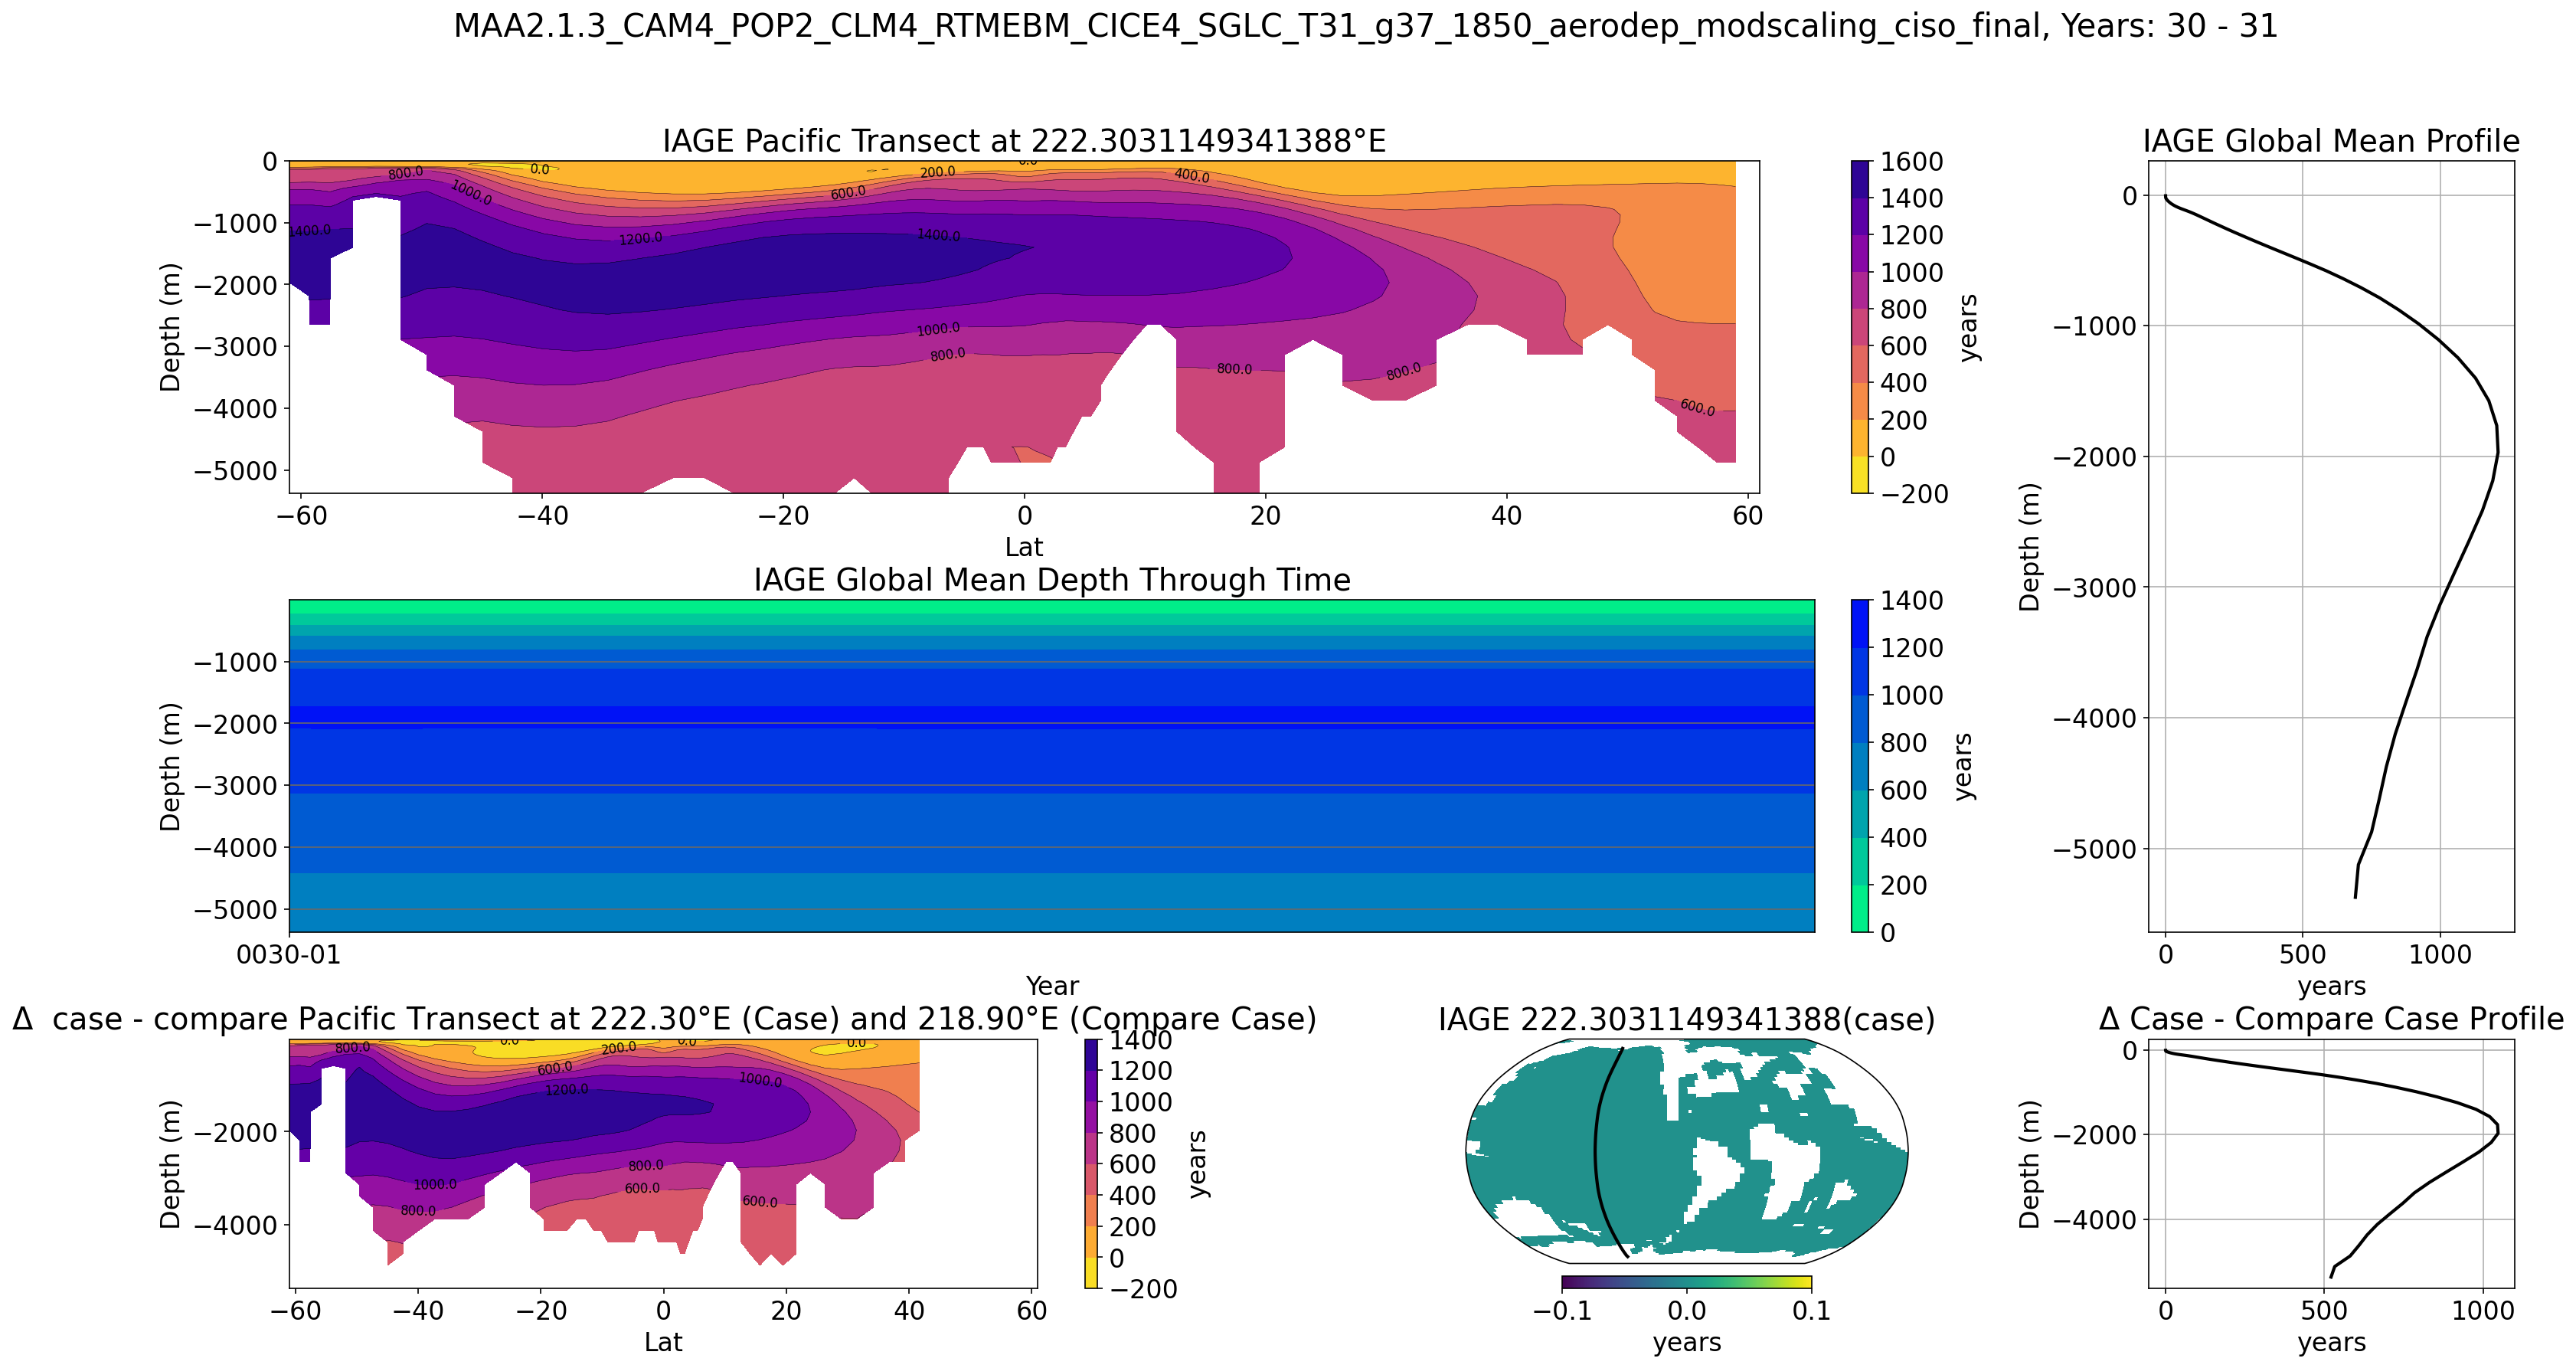

In [24]:
fig = plt.figure(figsize =(25,13),facecolor='white')
gs  = fig.add_gridspec(3, 5,width_ratios=[2.5,2.5,2.5,2.2, 2],height_ratios = [8,8,6], hspace=0.35,wspace=.05)
ax1 = fig.add_subplot(gs[0, 0:4])
ax2 = fig.add_subplot(gs[1, 0:4])
ax3 = fig.add_subplot(gs[0:2, 4])
ax4 = fig.add_subplot(gs[2, 0:2])
ax5 = fig.add_subplot(gs[2, 4])
ax6 =  fig.add_subplot(gs[2, 2:4],projection=ccrs.Robinson(central_longitude=-60))

#fig, (ax1, ax2,ax3) = plt.subplots(2, 2,2 ) 


fig.suptitle(caseName + ', Years: ' + str(startYear) + ' - ' + str(endYear), fontsize=20)

#################################Transect####################################
zmaxi = 82 #41

getTLATandTLONG = xr.open_mfdataset(casePath + caseName + '.pop.h.' + str(startYear).zfill(4)+ '-12'+'.nc',  decode_times=False)

mpl.rcParams['figure.figsize'] = [16,6]
clmap = 'plasma_r'

varData = np.mean(data[var][:,0:zmaxi,2:91,transectLong], axis = 0)

p = ax1.contourf(getTLATandTLONG[var].TLAT[2:91,transectLong], getTLATandTLONG[var].z_t[0:zmaxi]*(-1)*0.01, varData, cmap = clmap) #, levels, vmin = 32.8, vmax = 35.8, extend = 'both', cmap = cmap)
cbar = plt.colorbar(p, ax = ax1)
cbar.set_label(data[var].units)

cl = ax1.contour(getTLATandTLONG[var].TLAT[2:91,transectLong],getTLATandTLONG[var].z_t[0:zmaxi]*(-1)*0.01, varData,
                 colors = 'k', linewidths = 0.2)
plt.clabel(cl, fmt='%2.1f', colors='k', fontsize=8)#, ax = ax1)

ax1.set_xlim([-61, 61])
ax1.set_ylim(ymax=0)
ax1.set_xlabel('Lat')
ax1.set_ylabel('Depth (m)')

ax1.set_title(var+' Pacific Transect at '+str(getTLATandTLONG[var].TLONG[0,transectLong].values).zfill(4)+u"\N{DEGREE SIGN}"+'E')

#varData = np.mean(data[var][:,0:zmaxi,2:91,i], axis = 0)







#################################Depth#####################################
z_t = data.z_t
depthi = 60

clmap = 'winter_r'


p = ax2.contourf(dates, z_t[0:depthi]*(-1)*0.01, np.transpose(globalMean[:,0:depthi]), cmap = clmap)
cbar = plt.colorbar(p, ax = ax2, pad = 0.02)
cbar.set_label(var)
cbar.set_label(data[var].units)

ax2.set_ylabel('Depth (m)')
ax2.set_xlabel('Year')

ax2.set_xticks(ticks = years)
ax2.grid(color = 'dimgrey')

ax2.set_title(var + ' Global Mean Depth Through Time')

##############################Profile######################################
mean = np.mean(globalMean, axis = 0)


ax3.plot(mean, data.z_t*(-1)*0.01, 'k', label = var)


ax3.grid()

ax3.set_ylabel('Depth (m)')
ax3.set_xlabel(data[var].units)

ax3.set_title(var + ' Global Mean Profile')


##############################Transect Anomaly######################################
zmaxi = 82 #41

getTLATandTLONG = xr.open_mfdataset(casePath + caseName + '.pop.h.' + str(startYear).zfill(4) + '-12'+'.nc',  decode_times=False)


mpl.rcParams['figure.figsize'] = [16,6]
clmap = 'plasma_r'

varData = np.mean(data[var][:,0:zmaxi,2:91,transectLong], axis = 0) - np.mean(compareData[var][:,0:zmaxi,2:91,compareLong], axis = 0)

p = ax4.contourf(getTLATandTLONG[var].TLAT[2:91,transectLong], getTLATandTLONG[var].z_t[0:zmaxi]*(-1)*0.01, varData, cmap = clmap) #, levels, vmin = 32.8, vmax = 35.8, extend = 'both', cmap = cmap)
cbar = plt.colorbar(p,ax = ax4)
cbar.set_label(data[var].units)

cl = ax4.contour(getTLATandTLONG[var].TLAT[2:91,transectLong],getTLATandTLONG[var].z_t[0:zmaxi]*(-1)*0.01, varData, colors = 'k', linewidths = 0.2)
plt.clabel(cl, fmt='%2.1f', colors='k', fontsize=8)

ax4.set_xlim([-61, 61])

ax4.set_xlabel('Lat')
ax4.set_ylabel('Depth (m)')

ax4.set_title('$\Delta$ '+ ' case' + ' - ' + 'compare' + ' Pacific Transect at ' +"{:.2f}".format(getTLATandTLONG.TLONG[0,transectLong].values)+u"\N{DEGREE SIGN}"+'E (Case) and ' + "{:.2f}".format(compMask.TLONG[0,compareLong].values)+u"\N{DEGREE SIGN}"+'E (Compare Case)')

######################Profile Anomaly########################

mean = np.mean(globalMean, axis = 0) - np.mean(compareGlobalMean, axis = 0)


ax5.plot(mean, data.z_t*(-1)*0.01, 'k', label = var)



ax5.grid()

ax5.set_ylabel('Depth (m)')
ax5.set_xlabel(data[var].units)

ax5.set_title('$\Delta$ ' + 'Case - ' + 'Compare Case' + ' Profile')

#########Location Plot##########
ax6.set_global()
pop = pop_add_cyclic(getTLATandTLONG)
#use pcolor to plot the temperature, similar to all of the others
x,y = pop.variables['TLONG'], pop.variables['TLAT']
p = ax6.pcolor(x, y,pop[var][0,0,:,:], transform=ccrs.PlateCarree())

#add the colorbar to the plots
cbar = plt.colorbar(p, orientation='horizontal', pad=0.05, fraction=0.05,ax=ax6)
#cbar.ax.tick_params(labelsize=23)
cbar.set_label(pop[var].units)

#add a line to visualize the longitude
ax6.plot(data['TLONG'][:,transectLong].values,data['TLAT'][:,transectLong].values,color='k', transform=ccrs.PlateCarree(),zorder=10)
#print(temp_pop.TLAT[0,56].values)


ax6.set_title(var + ' ' +str(getTLATandTLONG[var].TLONG[0,transectLong].values).zfill(4) + '(case)')



if savePlot == True: 
    #swap  . and / in case name with '_'
    x = "./"
    y = "__"
    mytable = caseName.maketrans(x, y)
    
    
    fig.savefig(saveLocation+caseName.translate(mytable)+ ' Diagnostic', bbox_inches='tight', quality = 95, dpi = 500)
    
if regrid == True:
    #remove the remapped files created in the beginning
   # !rm /glade/scratch/vgarza/ScriptTempOutput/$caseName*
   # !rm /glade/scratch/vgarza/ScriptTempOutput/$compareName*
    !rm /glade/scratch/vgarza/ScriptTempOutput/WarningFile.txt